In [1]:
import findspark
findspark.init
from pyspark.sql import SparkSession, SQLContext
import pyspark.sql.functions as f
from pyspark.sql.types import StructType,StringType,IntegerType,MapType,ArrayType,StructField
from pyspark.sql.functions import count,when,col,isnan,from_json,explode,map_keys,udf,coalesce,lit,to_date,year,split,get_json_object,array,collect_list,concat_ws,regexp_replace,regexp_extract
from pyspark.sql.functions import row_number,lit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import sklearn
import random, os
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row
import random, os, gc

# Spark & ML
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import col, sqrt

import matplotlib


import tkinter as tk
from tkinter import ttk, messagebox
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import lit
from pyspark.sql.types import IntegerType, FloatType

In [2]:
!pip install -q findspark

In [3]:
spark = SparkSession.builder.appName('recsys').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/19 11:03:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Dataset Overview

In [4]:
movies = spark.read.load("sparkdata/movies.csv", format='csv', header = True)
ratings = spark.read.load('sparkdata/ratings.csv', format='csv', header = True)
links = spark.read.load("sparkdata/links.csv", format='csv', header = True)
tags = spark.read.load("sparkdata/tags.csv", format='csv', header = True)

In [5]:
movies.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [6]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [7]:
ratings.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [8]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [9]:
links.show()

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
|      6|0113277|   949|
|      7|0114319| 11860|
|      8|0112302| 45325|
|      9|0114576|  9091|
|     10|0113189|   710|
|     11|0112346|  9087|
|     12|0112896| 12110|
|     13|0112453| 21032|
|     14|0113987| 10858|
|     15|0112760|  1408|
|     16|0112641|   524|
|     17|0114388|  4584|
|     18|0113101|     5|
|     19|0112281|  9273|
|     20|0113845| 11517|
+-------+-------+------+
only showing top 20 rows



In [10]:
links.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: string (nullable = true)



In [11]:
tags.show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [12]:
tags.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: string (nullable = true)



# Data Preprocessing

### Type Conversion

In [13]:
ratings = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: string (nullable = true)



In [14]:
links = links.withColumn('tmdbId', links['tmdbId'].cast('int')).\
withColumn('movieId', links['movieId'].cast('int'))
links.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: integer (nullable = true)



In [15]:
tags = tags.withColumn('userId', tags['userId'].cast('int')).\
withColumn('movieId', tags['movieId'].cast('int'))
tags.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- tag: string (nullable = true)
 |-- timestamp: string (nullable = true)



### Null Count

In [16]:
datadict={'movies.csv':movies, 'rating.csv':ratings, 'links.csv':links, 'tags.csv':tags}

for key,value in datadict.items() :
  dfStats= value.select([count(when(col(c).isNull()|isnan(c),'True')).alias(c) for c,c_type in value.dtypes if c_type not in ('timestamp','boolean')])
  print("Column stats for data file :" +key+"\n")
  dfStats.show()

Column stats for data file :movies.csv

+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+

Column stats for data file :rating.csv

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      0|     0|        0|
+------+-------+------+---------+

Column stats for data file :links.csv

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      0|     0|     8|
+-------+------+------+

Column stats for data file :tags.csv

+------+-------+---+---------+
|userId|movieId|tag|timestamp|
+------+-------+---+---------+
|     0|      0|  0|        0|
+------+-------+---+---------+



### Duplicates Count

In [17]:
movies_sub = movies.groupby('movieId','title','genres').count().filter("count > 1").show()

#Total number of duplicate rows
movies.groupby('movieId','title','genres').count().where(f.col('count')>1).select(f.sum('count')).show()

+-------+-----+------+-----+
|movieId|title|genres|count|
+-------+-----+------+-----+
+-------+-----+------+-----+

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [18]:
ratings_sub = ratings.groupby('userId','movieId').count().filter("count > 1").show()
ratings.groupby('userId','movieId').count().where(f.col('count')>1).select(f.sum('count')).show()

+------+-------+-----+
|userId|movieId|count|
+------+-------+-----+
+------+-------+-----+

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [19]:
links_sub = links.groupby('movieId','imdbId','tmdbId').count().filter("count > 1").show()
links.groupby('movieId','imdbId','tmdbId').count().where(f.col('count')>1).select(f.sum('count')).show()

+-------+------+------+-----+
|movieId|imdbId|tmdbId|count|
+-------+------+------+-----+
+-------+------+------+-----+

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



In [20]:
tags_sub = tags.groupby('userId', 'movieId', 'tag').count().filter("count > 1").show()
tags.groupby('userId', 'movieId', 'tag').count().where(f.col('count')>1).select(f.sum('count')).show()

+------+-------+---+-----+
|userId|movieId|tag|count|
+------+-------+---+-----+
+------+-------+---+-----+

+----------+
|sum(count)|
+----------+
|      NULL|
+----------+



# EDA

### Summary Statistics

In [21]:
ratings.select('userId','movieId','rating','timestamp')\
  .summary("count", "min", "25%", "75%", "max").show()

+-------+------+-------+------+-------------+
|summary|userId|movieId|rating|    timestamp|
+-------+------+-------+------+-------------+
|  count|100836| 100836|100836|       100836|
|    min|     1|      1|   0.5|   1000129365|
|    25%|   177|   1199|   3.0|1.018535155E9|
|    75%|   477|   8092|   4.0|1.435993828E9|
|    max|   610| 193609|   5.0|    999873731|
+-------+------+-------+------+-------------+



In [22]:
links.select('movieId','tmdbId')\
  .summary("count", "min", "25%", "75%", "max").show()

+-------+-------+------+
|summary|movieId|tmdbId|
+-------+-------+------+
|  count|   9742|  9734|
|    min|      1|     2|
|    25%|   3247|  9664|
|    75%|  76175| 44181|
|    max| 193609|525662|
+-------+-------+------+



In [23]:
tags.select('userId', 'movieId', 'timestamp')\
  .summary("count", "min", "25%", "75%", "max").show()

+-------+------+-------+-------------+
|summary|userId|movieId|    timestamp|
+-------+------+-------+-------------+
|  count|  3683|   3683|         3683|
|    min|     2|      1|   1137179352|
|    25%|   424|   1262|1.137521204E9|
|    75%|   477|  39292|1.498456766E9|
|    max|   610| 193565|   1537098603|
+-------+------+-------+-------------+



### Analysis of Distribution

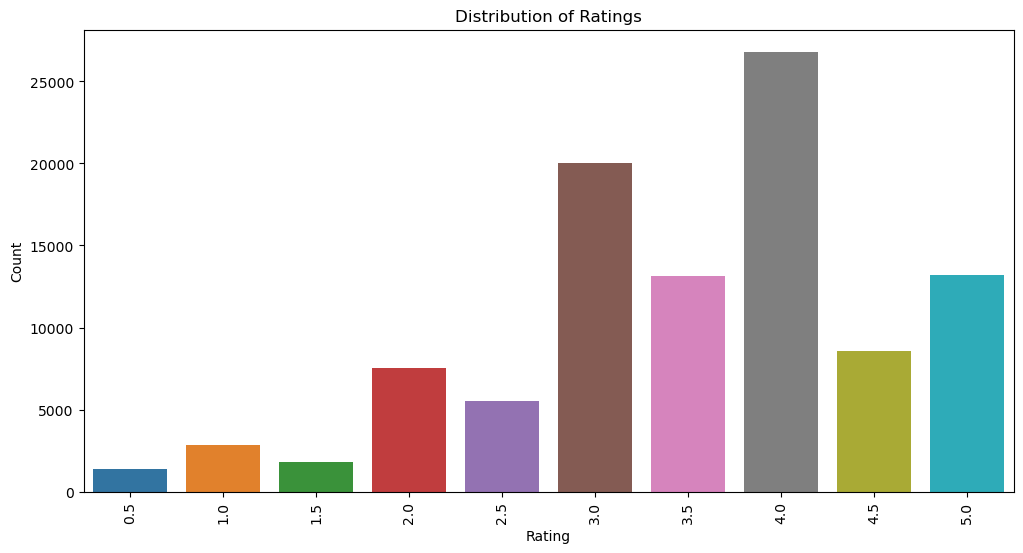

In [24]:
ratings_distribution = ratings.groupBy('rating').count().orderBy('rating').toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(x='rating', y='count', data=ratings_distribution)
plt.xticks(rotation=90)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

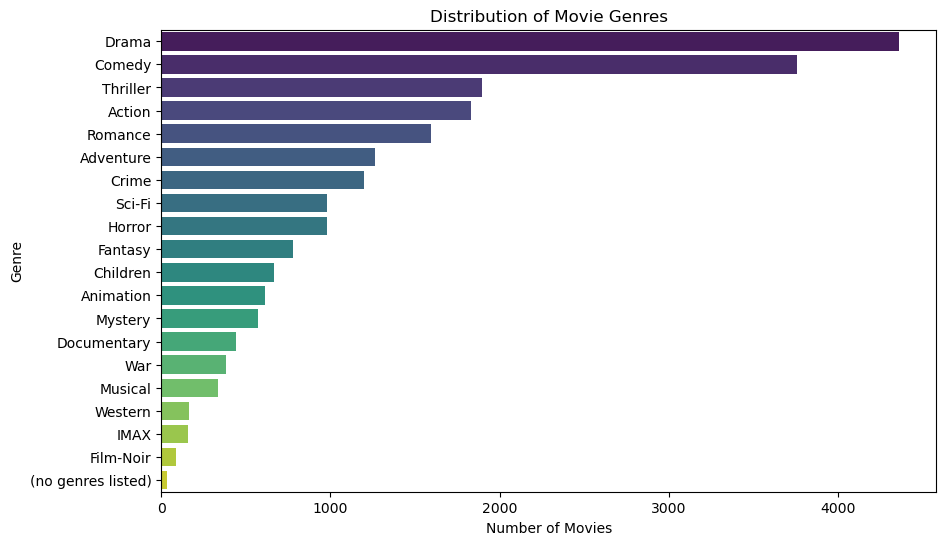

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

genre_counts = movies.select("genres").rdd.flatMap(lambda x: x[0].split("|")).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y).collect()

# Convert the genre counts to a DataFrame
genre_counts_df = spark.createDataFrame(genre_counts, ["genre", "count"])

# Plot the genre distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="genre", data=genre_counts_df.sort("count", ascending=False).toPandas(), palette="viridis")
plt.title("Distribution of Movie Genres")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.show()


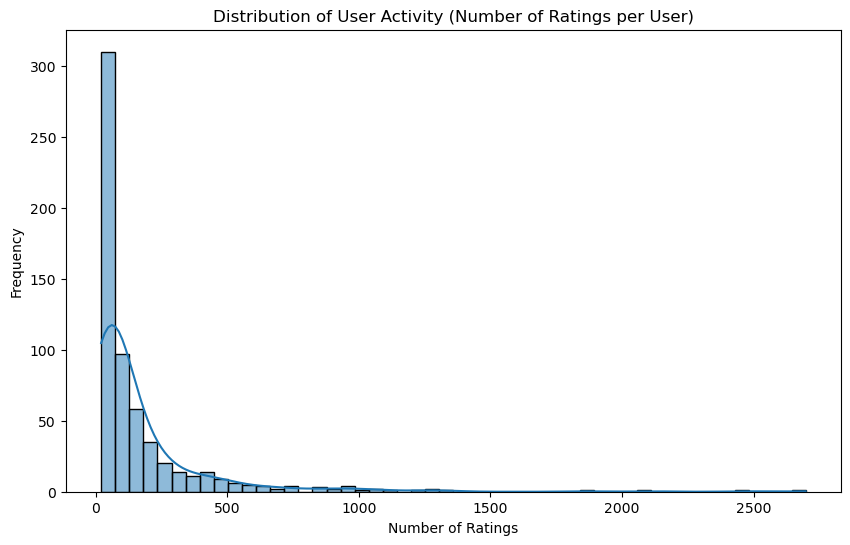

In [26]:
ratings = ratings.withColumn("userId", ratings["userId"].cast("int"))
ratings = ratings.withColumn("rating", ratings["rating"].cast("float"))

# Group ratings by userId and count the number of ratings for each user
user_activity = ratings.groupBy("userId").count().toPandas()

# Plotting user activity distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=user_activity, x="count", bins=50, kde=True)
plt.title('Distribution of User Activity (Number of Ratings per User)')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.show()

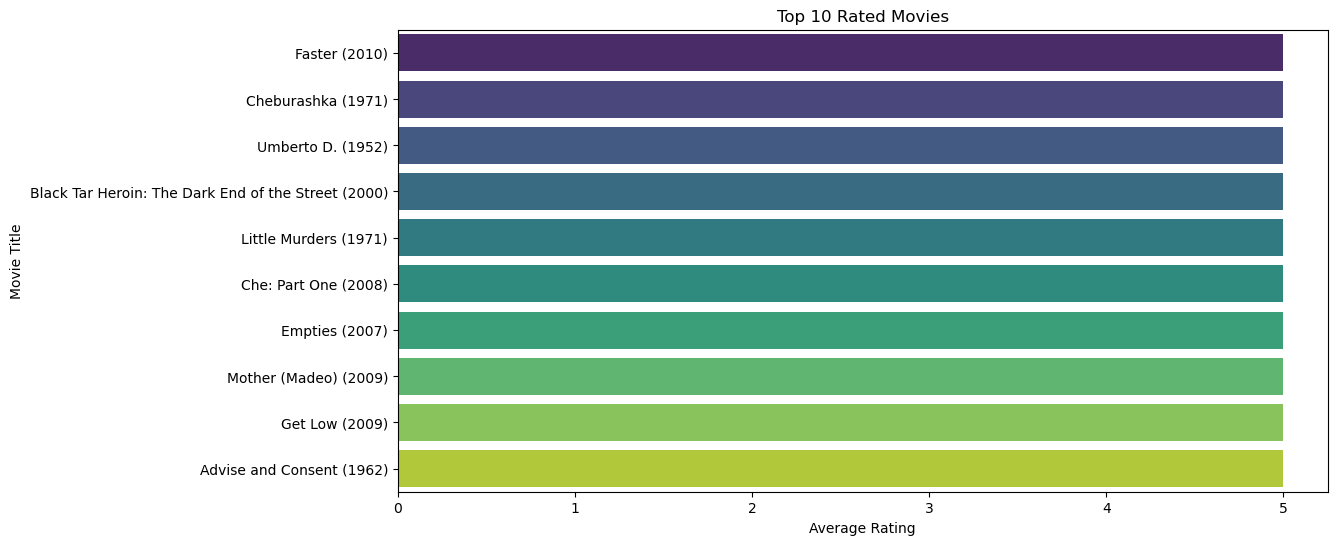

In [27]:
avg_ratings_pd = ratings.groupBy('movieId').avg('rating').withColumnRenamed('avg(rating)', 'avg_rating')
movies_pd = movies.selectExpr('cast(movieId as int) as movieId', 'title').toPandas()

avg_ratings_pd = avg_ratings_pd.toPandas()
top_rated_movies = pd.merge(avg_ratings_pd, movies_pd, on='movieId')
top_rated_movies = top_rated_movies.sort_values(by='avg_rating', ascending=False)
top_10_rated_movies = top_rated_movies.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='avg_rating', y='title', data=top_10_rated_movies, palette='viridis')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.title('Top 10 Rated Movies')
plt.show()

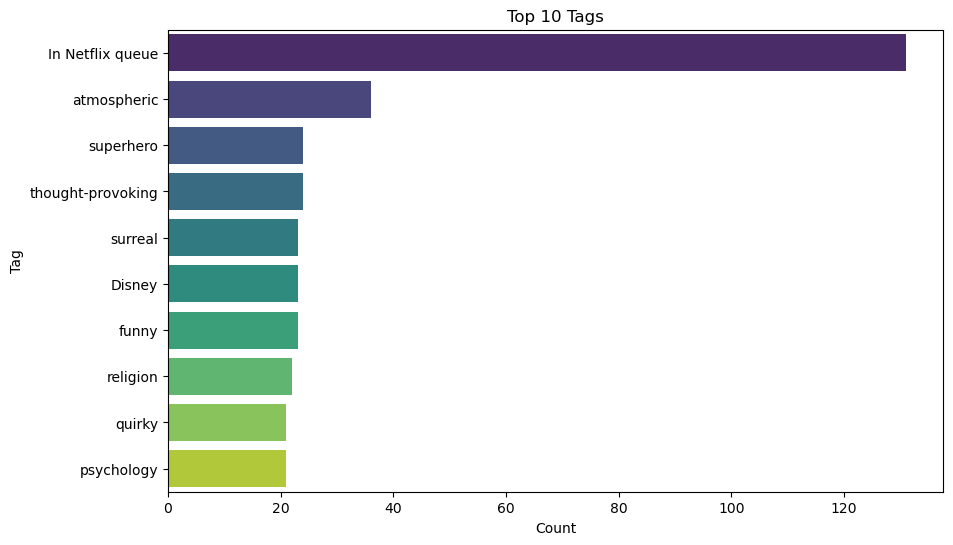

In [28]:
tag_counts = tags.groupBy('tag').count().orderBy('count', ascending=False).toPandas()

# Plot the top N tags
top_n = 10  # Change this value if you want to plot more or fewer tags
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='tag', data=tag_counts.head(top_n), palette='viridis')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.title(f'Top {top_n} Tags')
plt.show()

# Recsys Model

In [29]:
ratings = ratings.drop("timestamp")
df = ratings.withColumn('userId', ratings['userId'].cast('int')).\
withColumn('movieId', ratings['movieId'].cast('int')).withColumn('rating', ratings['rating'].cast('float'))
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)



In [30]:
# split the data into train, validation and test sets
train, validation, test = df.randomSplit([0.6,0.2,0.2], seed = 0)
print("The number of ratings in each set: {}, {}, {}".format(train.count(), validation.count(), test.count()))

The number of ratings in each set: 60435, 20052, 20349


In [31]:
def RMSE(predictions):
    squared_diff = predictions.withColumn("squared_diff", pow(col("rating") - col("prediction"), 2))
    mse = squared_diff.selectExpr("mean(squared_diff) as mse").first().mse
    return mse ** 0.5

In [32]:
def GridSearch(train, valid, num_iterations, reg_param, n_factors):
    min_rmse = float('inf')
    best_n = -1
    best_reg = 0
    best_model = None
    # run Grid Search for all the parameter defined in the range in a loop
    for n in n_factors:
        for reg in reg_param:
            als = ALS(rank = n, 
                      maxIter = num_iterations, 
                      seed = 0, 
                      regParam = reg,
                      userCol="userId", 
                      itemCol="movieId", 
                      ratingCol="rating", 
                      coldStartStrategy="drop")            
            model = als.fit(train)
            predictions = model.transform(valid)
            rmse = RMSE(predictions)     
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(n, reg, rmse))
            # track the best model using RMSE
            if rmse < min_rmse:
                min_rmse = rmse
                best_n = n
                best_reg = reg
                best_model = model
                
    pred = best_model.transform(train)
    train_rmse = RMSE(pred)
    # best model and its metrics
    print('\nThe best model has {} latent factors and regularization = {}:'.format(best_n, best_reg))
    print('traning RMSE is {}; validation RMSE is {}'.format(train_rmse, min_rmse))
    return best_model

In [33]:
import time
num_iterations = 10
ranks = [6, 8, 10, 12]
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]
start_time = time.time()
final_model = GridSearch(train, validation, num_iterations, reg_params, ranks)
print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

24/04/19 11:04:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/19 11:04:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


6 latent factors and regularization = 0.05: validation RMSE is 0.9774929328788823
6 latent factors and regularization = 0.1: validation RMSE is 0.9129091223429058
6 latent factors and regularization = 0.2: validation RMSE is 0.8951553382560972
6 latent factors and regularization = 0.4: validation RMSE is 0.9694803178313401
6 latent factors and regularization = 0.8: validation RMSE is 1.1934058854574956
8 latent factors and regularization = 0.05: validation RMSE is 0.991145449065857
8 latent factors and regularization = 0.1: validation RMSE is 0.9168968752992065
8 latent factors and regularization = 0.2: validation RMSE is 0.8984989590130781
8 latent factors and regularization = 0.4: validation RMSE is 0.970257089065676
8 latent factors and regularization = 0.8: validation RMSE is 1.1934001722789012
10 latent factors and regularization = 0.05: validation RMSE is 0.9978579799721213


10 latent factors and regularization = 0.1: validation RMSE is 0.917667217329484


10 latent factors and regularization = 0.2: validation RMSE is 0.89872811595771
10 latent factors and regularization = 0.4: validation RMSE is 0.9695217458657989


10 latent factors and regularization = 0.8: validation RMSE is 1.1934037198726448
12 latent factors and regularization = 0.05: validation RMSE is 1.0053856065363034
12 latent factors and regularization = 0.1: validation RMSE is 0.9177483821613751
12 latent factors and regularization = 0.2: validation RMSE is 0.9000614069040118
12 latent factors and regularization = 0.4: validation RMSE is 0.9701108570324755
12 latent factors and regularization = 0.8: validation RMSE is 1.193400724202843



The best model has 6 latent factors and regularization = 0.2:
traning RMSE is 0.6876113846732682; validation RMSE is 0.8951553382560972
Total Runtime: 163.26 seconds


In [34]:
pred_test = final_model.transform(test)
print('The testing RMSE is ' + str(RMSE(pred_test)))

The testing RMSE is 0.8959197572737135


In [36]:
spark = SparkSession.builder.appName('recommendation').getOrCreate()
matplotlib.use('Agg')

def recommend_similar_movies(movie_list_input):
    global spark
    
    movie_list = [movie.strip() for movie in movie_list_input.split(',')]
    movie_ids = movies.select("movieId", "title").filter(movies["title"].isin(movie_list))
    user_ratings = movie_ids.join(ratings, "movieId")
    user_ratings = user_ratings.withColumn("userId", lit(0))
    user_ratings = user_ratings.withColumn("movieId", user_ratings["movieId"].cast(IntegerType()))
    user_ratings = user_ratings.withColumn("rating", user_ratings["rating"].cast(FloatType()))
    user_ratings = user_ratings.select("userId", "movieId", "rating")
    user_data = train.union(user_ratings)
    updated_model = ALS(rank=final_model.rank, maxIter=final_model._java_obj.parent().getMaxIter(),
                        seed=final_model._java_obj.parent().getSeed(),
                        regParam=final_model._java_obj.parent().getRegParam(),
                        userCol="userId", itemCol="movieId", ratingCol="rating",
                        coldStartStrategy="drop").fit(user_data)
    user_movies_df = user_ratings.select("userId", "movieId").distinct()
    recommendations = updated_model.recommendForUserSubset(user_movies_df, 10)
    recommended_movie_ids = [recommendation.movieId for recommendation in recommendations.select("recommendations").collect()[0][0]]
    recommended_movies_titles = movies.select("movieId", "title").filter(movies["movieId"].isin(recommended_movie_ids))

    recommended_movies = recommended_movies_titles.collect()
    recommended_movie_titles = [movie.title for movie in recommended_movies]
    return recommended_movie_titles

def on_submit():
    movie_list_input = entry.get()
    if movie_list_input:
        recommendations = recommend_similar_movies(movie_list_input)
        if recommendations:
            messagebox.showinfo("Recommendations", "\n".join(recommendations))
        else:
            messagebox.showwarning("No Recommendations", "No recommendations found for the provided movies.")
    else:
        messagebox.showwarning("Empty Input", "Please enter at least one movie.")

root = tk.Tk()
root.title("Movie Recommendation System")

label = ttk.Label(root, text="Enter movie names (separated by commas), each followed by its release year (in parentheses):")
label.pack(pady=10)

entry = ttk.Entry(root, width=50)
entry.pack(pady=5)

submit_button = ttk.Button(root, text="Submit", command=on_submit)
submit_button.pack(pady=5)

popular_movies_text = """
### Drama:
1. The Shawshank Redemption (1994)
2. Schindler's List (1993)
3. Forrest Gump (1994)
4. Fight Club (1999)
5. Saving Private Ryan (1998)
6. The Prestige (2006)
7. Whiplash (2014)
8. The Sixth Sense (1999)

### Crime:
1. The Godfather (1972)
2. Pulp Fiction (1994)
3. The Silence of the Lambs (1991)
4. The Green Mile (1999)
5. The Godfather: Part II (1974)
6. Se7en (1995)
7. The Departed (2006)
8. The Usual Suspects (1995)

### Action/Adventure:
1. The Dark Knight (2008)
2. The Lord of the Rings Trilogy (2001-2003)
3. Inception (2010)
4. The Matrix (1999)
5. Star Wars: Episode V - The Empire Strikes Back (1980)
6. Gladiator (2000)
7. Interstellar (2014)
8. Back to the Future (1985)
9. The Avengers (2012)

### Biography:
1. The Intouchables (2011)
2. The Wolf of Wall Street (2013)

### Animation:
1. The Lion King (1994)
2. Spirited Away (2001)
3. Toy Story Trilogy (1995-2010)
4. Finding Nemo (2003)
5. WALL-E (2008)
6. Coco (2017)
7. Shrek (2001)
8. Frozen (2013)
9. How to Train Your Dragon Trilogy (2010-2019)
10. Zootopia (2016)
"""
text_widget = tk.Text(root, height=50, width=100)
text_widget.insert(tk.END, popular_movies_text)
text_widget.pack(pady=10)
text_widget.config(state=tk.DISABLED)
root.mainloop()

24/04/19 11:41:45 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/04/19 13:12:29 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1077086 ms exceeds timeout 120000 ms
24/04/19 13:12:29 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/19 13:12:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockMan

24/04/19 13:30:21 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 13:31:14 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 13:48:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:04:34 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:04:44 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:04:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:22:27 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:23:21 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 14:24:15 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 14:24:25 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 14:57:32 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:14:37 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:25:45 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:26:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:26:30 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:26:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:42:19 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:43:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:57:49 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 15:57:59 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 15:59:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 16:00:32 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

24/04/19 16:00:42 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 16:00:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 16:06:20 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

24/04/19 16:09:08 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE